In [62]:
# creating model and using feature extraction to find different features and reduce curse of dimensionality
import numpy as np
import cv2
import pandas as pd
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage.feature import local_binary_pattern

In [63]:
def calculate_hog_features(image):
    hog_image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_AREA)
    fd, hog_image = hog(hog_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

In [64]:
# https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

def lbp_feature_selection(image):
    lbp = local_binary_pattern(image, 24, 3, )
    

    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2))
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    # return the histogram of Local Binary Patterns
    
    return hist

In [65]:
# loading in images and turing it into an array to use as features, collecting labels
path = os.getcwd()

path = os.path.join(path, 'dataset')
df_labels = pd.read_csv(os.path.join(path, 'label.csv'))

# getting train and test dataframes
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

classes = {'meningioma_tumor': 0, 'no_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}

def feature_extraction(dataset, img_path):
    features = []
    labels = []
    for row in dataset.iterrows():
        image_name = row[1][0]
        label = row[1][1]
        # opening and flattening image
        img = cv2.imread(os.path.join(img_path, image_name))
        # images are gray scale so there is useless data using RGB
        grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # calculating hog features
        # fd, hog_image = calculate_hog_features(grayscale)
        fd = []
        # calculating LBP
        lbp_hist = lbp_feature_selection(grayscale)
        

        features.append(np.concatenate((fd, lbp_hist)))
        labels.append(classes.get(label))
    return features, labels

train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

x_train, y_train = feature_extraction(train, train_path)
x_test, y_test = feature_extraction(test, test_path)

print('Train size: ', len(x_train))
print('Test size: ', len(x_test))
# add progress bar


Train size:  2100
Test size:  900


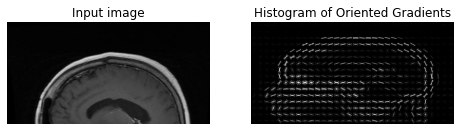

In [66]:
# testing out hog from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
import matplotlib.pyplot as plt
from skimage import data, exposure
fd, hog_image = calculate_hog_features(grayscale)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(grayscale, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [67]:
img = cv2.imread('./dataset/image/IMAGE_0000.jpg')
# images are gray scale so there is useless data using RGB
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hist = lbp_feature_selection(grayscale)
print(hist)

[7.83556894e-01 4.65370928e-02 5.83994890e-03 3.85071631e-02
 7.11743772e-03 1.82498403e-04 1.00374122e-02 3.33972078e-02
 1.17711470e-02 1.82498403e-04 0.00000000e+00 1.82498403e-04
 1.23186422e-02 1.82498403e-04 1.04936582e-02 2.12610640e-02
 5.20120449e-03 9.12492016e-05 0.00000000e+00 0.00000000e+00
 3.64996806e-04 0.00000000e+00 0.00000000e+00 2.73747605e-04
 1.21361438e-02 3.64996806e-04]


In [68]:
# PCA fitting for dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def dimensionality_reduction(x_train, x_test):
    scalar = StandardScaler()

    # scaling data to perform pca on it
    scalar.fit(x_train)

    # applying scale to xtrain and xtest
    x_train = scalar.transform(x_train)
    x_test = scalar.transform(x_test)


    # creating pca
    pca = PCA(.95)

    # fitting pca on training data
    pca.fit(x_train)

    # applying to train and test
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    return x_train, x_test

In [69]:
x_train, x_test = dimensionality_reduction(x_train, x_test)

In [70]:
# creating and training SVM on training data
model_dimension_reduction = SVC(C=1, kernel='linear', gamma='auto')

model_dimension_reduction.fit(x_train, y_train)

SVC(C=1, gamma='auto', kernel='linear')

In [71]:
# getting accuracy metrics and printing
pred = model_dimension_reduction.predict(x_test)
score = accuracy_score(y_test, pred)
print('accuracy: ', score)

accuracy:  0.5344444444444445


In [72]:
print(x_train[0].shape)

(21,)


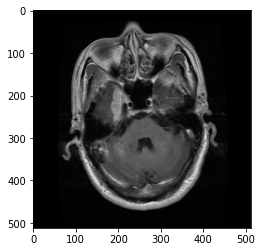

In [73]:
# showing images which model failed on
y_pred = model_dimension_reduction.predict(x_test)
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        if i<10:
            img = cv2.imread(f'./dataset/image/IMAGE_000{i}.jpg')
        elif i<100:
            img = cv2.imread(f'./dataset/image/IMAGE_00{i}.jpg')
        elif i<1000:
            img = cv2.imread(f'./dataset/image/IMAGE_0{i}.jpg')
        else:
            img = cv2.imread(f'./dataset/image/IMAGE_{i}.jpg')
        plt.imshow(img)